Meant to be a tool to help with the understanding of VAE's. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
from tqdm import tqdm

Import the MNIST dataset.

In [2]:
# Define batch size variables for our training data
batch_size_train = 64

# todo: learn what a dataloader is.
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])), batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                  torchvision.transforms.ToTensor()
                              ])))


## ChatGPT's Explination for the Code Above:
The code you provided sets up data loaders for the MNIST dataset in PyTorch, which are used for loading and batching the data during training and testing of a machine learning model. Let's break down the code and understand what each part does:

torch.utils.data.DataLoader: This is a PyTorch utility for creating data loaders, which are used for loading and batching data during training or testing.

datasets.MNIST: This is a PyTorch built-in dataset class for the MNIST dataset, which is a widely used dataset of handwritten digits.

root: This is the directory where the MNIST dataset will be downloaded and stored.

train=True / train=False: This specifies whether to load the training set (train=True) or the test set (train=False) of the MNIST dataset.

download=True: This indicates that the dataset should be downloaded if it doesn't already exist in the specified root directory.

transform: This is an optional argument that specifies the data transformation pipeline to be applied on the loaded data. In this case, the pipeline includes converting the images to tensors (torchvision.transforms.ToTensor()) and normalizing the pixel values of the images to a specified mean and standard deviation using torchvision.transforms.Normalize().

batch_size: This specifies the number of samples to be loaded and processed together in each batch during training or testing.

shuffle: This indicates whether to shuffle the data during loading. If set to True, the data will be shuffled randomly at the beginning of each epoch during training, which helps in improving the model's ability to generalize.

So, train_loader and test_loader are data loaders that are set up to load and batch the MNIST dataset for training and testing respectively, with specified data transformations, batch sizes, and shuffling settings. These data loaders can be used in a PyTorch model training loop to iterate over the data and feed it to the model for training or testing.


#### Dataloader Cheatsheet


torch.Size([1, 28, 28])



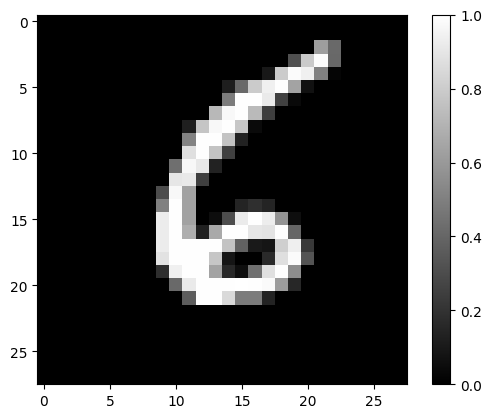

In [3]:
print(train_loader)
for i, data in enumerate(train_loader):
    x_imgs, labels = data
    img = x_imgs[0]
    img_auto = img
    print(img.shape)
    image = img.numpy()
    
    plt.imshow(np.squeeze(image), cmap='gray')
    plt.colorbar()
    print()
    break
    

My initial understanding of a VAE is that it follows a similar form to that of a convolutional network + a up-convolutional network. 



In [4]:
import torch.nn as nn

class Autoencoder():
    def __init__(self):
        
        # predicts both mean and standard deviation
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3),
            nn.ReLU(),
            
            nn.Conv2d(16, 8, kernel_size = 3),
            nn.ReLU(),
            
            nn.Flatten(start_dim=0),
            nn.Linear(4608, 20)
        )
        
        # doesn't take input from encoder directly
        self.decoder = nn.Sequential(
            nn.Linear(20,4608),
            nn.Unflatten(0, torch.Size([8, 24, 24])),
            nn.ConvTranspose2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
            
        )
        

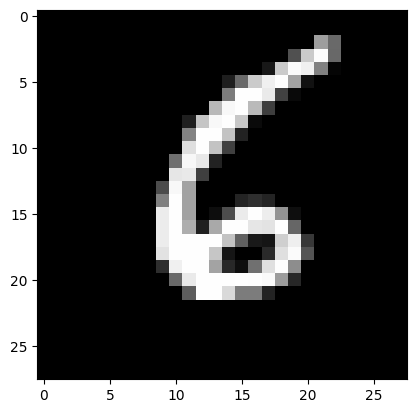

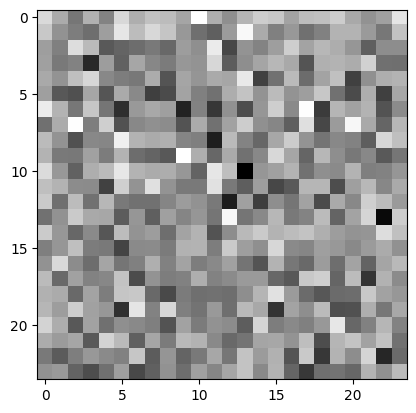

In [5]:
temp_vae = Autoencoder()

plt.imshow(np.squeeze(img), cmap='gray')
plt.show()

latent = temp_vae.encoder(img)
x_prime = temp_vae.decoder(latent)
#print(x_prime)
x_prime = x_prime.detach().numpy()
plt.imshow(np.squeeze(x_prime), cmap='gray')
plt.show()


Vaguely certain that the model I created above would be an example of just a normal autoencoder, as it has no means of recognizing or differentiating mean and standard distributions. 

The main difference between autoencoders that are variational is that the latent variables for VAE's are stochastic. 
We split our latent space into two 'types' of latent variables, means and standard distributions, which both make up pairs of latent variable distributions (often normally distributed?)

As far as I can understand, the stnd dev and mean variables are split into two different layers.

In other words, the latent space isn't nessessarily represented as a part of a machine learning model, it is just the consequence of it. 

todo: test the difference in functionality between relu and leakyrelu




In [36]:
# Define dimentionality for model 
channel_dim = [16, 32, 64]

class VariationalAutoEncoder(nn.Module):
    def __init__(self, channel_dim):
        super(VariationalAutoEncoder, self).__init__()
        
        self.channel_dim = [16, 32, 64]
        self.LR = 1e-4

        # Basic structure, as far as I know is 
        # Encoder model
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 40, kernel_size = 3),
            nn.ReLU(),
            
            nn.Conv2d(40, 20, kernel_size = 3),
            nn.ReLU(),
            
            nn.Flatten(start_dim=1),
            
            # 512 = 8^3 = 4 * 4 * 64, where the image should be 4x4 and 64 filters. 
            nn.Linear(2000, 100)
        )
        # Latent-space representation
        
        self.latent_mean = nn.Linear(100, 50)
        self.latent_var = nn.Linear(100, 50)
        
        # Decoder model
        #self.channel_dim = list(reversed(self.channel_dim)) # channel_dim = [64, 32, 16]
        
        # The decoder model takes a sample from the two latent space representations as an input.
        # We then note that unlike other neural networks, we have to make a function that
        # sequences through these networks in a 'correct' way, as the networks aren't connected
        # like they would in many other models. 
        
        self.decoder = nn.Sequential(
            nn.Linear(50, 2000),
            
            nn.Unflatten(1, torch.Size([20, 10, 10])),

            nn.ConvTranspose2d(20, 40, kernel_size = 3, stride = 1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(40, 1, kernel_size = 3, stride = 1),
            #nn.ReLU(),
            
            #nn.Conv2d(16, 1, kernel_size = 3, padding = 1),
            
            nn.Sigmoid()
        )
        
        #self.optimizers = {'encoder': torch.optim.Adam(self.encoder.parameters(), self.LR), 
        #                  'decoder': torch.optim.Adam(self.decoder.parameters(), self.LR), 
        #                 'latent_mean': torch.optim.Adam(self.latent_mean.parameters(), self.LR), 
        #                  'latent_var': torch.optim.Adam(self.latent_var.parameters(), self.LR)}
        
        self.optimizer = torch.optim.Adam(self.parameters(), self.LR)
        
    def reparametrization(self, sample_mean, sample_logvar):
        '''
        We define a new tensor epsilon with the same batch size as two inputted tensors,
        all of epsilon should be normally distributed.
        
        To be clear: epsilon is a tensor with stand_dev dimentionality, each input being a 
        sample from a standard normal. We then shift each of these to model 'our normal distribution' 
       
        '''
        
        stand_dev = torch.exp(0.5 * sample_logvar)
        epsilon = torch.randn_like(stand_dev)
        sampled_batch = epsilon*stand_dev + sample_mean
        return sampled_batch
    
    def encode(self, input_img):
        ''' 
        We note that because the encoding functionality in variational autoencoders breaks off the input into two seperate layers,
        we have to make a seperate function for encoding, rather than simply passing it through the network.
        '''
        encoded_input = self.encoder(input_img)
        
        encoded_mean = self.latent_mean(encoded_input)
        encoded_var = self.latent_var(encoded_input)
        
        return [encoded_mean, encoded_var]
    
    def decode(self, input_img):
        '''
        We note that our input is already reparametrized, so we don't need to worry about that.
        It get's reparameterized in the forward pass. 
        
        '''
        return self.decoder(input_img)
    
    def forward(self, input_image):
        '''
        Forward passes seem to be simple enough. 
        '''
        latent_rep: list = self.encode(input_image)
        reparam_latent = self.reparametrization(latent_rep[0], latent_rep[1])
        sampled_image = self.decoder(reparam_latent)
        #print(sampled_image.shape)
        
        return sampled_image, latent_rep
    
    def backpropogation(self):
        pass
    
    def loss(self, input_img, reconstruction, mean, log_var) -> dict:
        '''
        There are two primary terms for the loss function in question. The first is the 
        reconstruction loss, and the other is the KL-divergence. Both measure different things.
        
        Reconstruction loss is just the difference between the pixels of the two images. It would 
        be higher, for example, if in one image there was a pixel of 240 and the other had an image
        of 5. We will just use standard MSE for this difference.
        
        KL-divergence accounts for our latent variables. Since we want our latent variables to 
        model some sort of gausian/normal distribution, we can punish our latent variables for any
        deviation between what it currently is and what a normal dist looks like. 
        
        In our case, because we try to find the difference between our mean and var and that of a 
        stnd. normal, we can justify that the kl divergence simplifies to 
        -1/2 * sum(1 + log(var) - mean^2 - var)
        '''
        input_img = input_img
        reconstruction = reconstruction
        
        reconstruction_loss = nn.functional.mse_loss(input_img, reconstruction)
                
        kl_div = torch.mean(-0.5*torch.sum(1 + log_var - mean**2 - torch.exp(log_var)))
        
        total_loss = reconstruction_loss  + (1/(1000*64))*kl_div
        
        #print("reconstructed loss: ", reconstruction_loss)
        #print("kl_div: ", kl_div)
        #print("total loss: ", total_loss)
        
        
        return {'loss' : total_loss, 'reconstruction_loss' : reconstruction_loss, 
                'kl_divergence' : kl_div}
        
    
    
        



In [65]:
''' Now we train the network '''
train_network = VariationalAutoEncoder(channel_dim)

epochs = 100
for e in tqdm(range(epochs)):
    kl_loss = 0.0
    reconstruction_loss = 0.0
    for batch_images, _ in train_loader:
        
        batch_images = batch_images[:,:, ::2, ::2]
        #batch_images = batch_images[:, :, 1:-1, 1:-1]
        
        train_network.optimizer.zero_grad()
        
        images, latent_rep = train_network.forward(batch_images)
        
        loss = train_network.loss(batch_images, images, latent_rep[0], latent_rep[1])
        
        #print('kld: ',loss['kl_divergence'].shape)
        #print('recons: ', loss['reconstruction_loss'].shape)
        
        kld_loss = loss['kl_divergence'].detach().numpy()
        recons = loss['reconstruction_loss'].detach().numpy()
        #print(added_loss)
        kl_loss += kld_loss
        reconstruction_loss += recons
        
        loss['loss'].backward()
        
        #for network in train_network.optimizer:
        #    optimizer = train_network.optimizer[network]
        #    optimizer.zero_grad()
        #    optimizer.step()
        
        #parameters = train_network.parameters
        #optimizer = train_network.optimizer
        train_network.optimizer.step()
        
        
    else:
        print('kl_loss ', kl_loss)
        print('recons loss ', reconstruction_loss)

  1%|▍                                          | 1/100 [00:12<20:46, 12.59s/it]

kl_loss  898173.1631660461
recons loss  55.301709685474634


  2%|▊                                          | 2/100 [00:24<20:17, 12.43s/it]

kl_loss  1040089.3355712891
recons loss  30.423002840951085


  3%|█▎                                         | 3/100 [00:37<20:05, 12.43s/it]

kl_loss  1073566.7627563477
recons loss  25.62320875003934


  4%|█▋                                         | 4/100 [00:52<21:34, 13.49s/it]

kl_loss  1082765.7888793945
recons loss  22.93238533847034


  5%|██▏                                        | 5/100 [01:03<19:57, 12.61s/it]

kl_loss  1074446.5838012695
recons loss  21.343626849353313


  6%|██▌                                        | 6/100 [01:14<18:47, 12.00s/it]

kl_loss  1063718.01953125
recons loss  20.307880071923137


  7%|███                                        | 7/100 [01:25<17:59, 11.61s/it]

kl_loss  1055463.1322631836
recons loss  19.584936609491706


  8%|███▍                                       | 8/100 [01:36<17:27, 11.38s/it]

kl_loss  1045375.118347168
recons loss  19.077114813029766


  9%|███▊                                       | 9/100 [01:46<17:00, 11.22s/it]

kl_loss  1038803.1962280273
recons loss  18.66170940361917


 10%|████▏                                     | 10/100 [01:58<16:49, 11.22s/it]

kl_loss  1033409.6184082031
recons loss  18.325388794764876


 11%|████▌                                     | 11/100 [02:10<17:10, 11.58s/it]

kl_loss  1027975.8689575195
recons loss  18.089775811880827


 12%|█████                                     | 12/100 [02:21<16:54, 11.53s/it]

kl_loss  1021245.1167602539
recons loss  17.888320373371243


 13%|█████▍                                    | 13/100 [02:33<16:45, 11.56s/it]

kl_loss  1017903.7435302734
recons loss  17.66584892384708


 14%|█████▉                                    | 14/100 [02:45<16:56, 11.81s/it]

kl_loss  1015881.1798095703
recons loss  17.481677321717143


 15%|██████▎                                   | 15/100 [02:57<16:30, 11.65s/it]

kl_loss  1012948.7256469727
recons loss  17.314370831474662


 16%|██████▋                                   | 16/100 [03:10<17:05, 12.21s/it]

kl_loss  1010591.1607666016
recons loss  17.177002981305122


 17%|███████▏                                  | 17/100 [03:23<16:57, 12.26s/it]

kl_loss  1010991.1094360352
recons loss  17.054317474365234


 18%|███████▌                                  | 18/100 [03:33<16:10, 11.83s/it]

kl_loss  1010287.133972168
recons loss  16.922029091976583


 19%|███████▉                                  | 19/100 [03:45<15:49, 11.72s/it]

kl_loss  1012398.395690918
recons loss  16.818111047148705


 20%|████████▍                                 | 20/100 [03:57<15:37, 11.72s/it]

kl_loss  1010092.1923217773
recons loss  16.72752201091498


 21%|████████▊                                 | 21/100 [04:08<15:27, 11.74s/it]

kl_loss  1008913.0550537109
recons loss  16.633148979395628


 22%|█████████▏                                | 22/100 [04:20<15:10, 11.67s/it]

kl_loss  1008487.707824707
recons loss  16.540311614982784


 23%|█████████▋                                | 23/100 [04:32<15:11, 11.84s/it]

kl_loss  1007709.192565918
recons loss  16.455745654180646


 24%|██████████                                | 24/100 [04:44<15:07, 11.94s/it]

kl_loss  1007937.3901977539
recons loss  16.38767324667424


 25%|██████████▌                               | 25/100 [04:57<15:10, 12.14s/it]

kl_loss  1006614.8680725098
recons loss  16.313390628434718


 26%|██████████▉                               | 26/100 [05:09<15:02, 12.19s/it]

kl_loss  1007544.5167236328
recons loss  16.26483103260398


 27%|███████████▎                              | 27/100 [05:21<14:48, 12.17s/it]

kl_loss  1005335.5780639648
recons loss  16.202198525890708


 28%|███████████▊                              | 28/100 [05:33<14:27, 12.05s/it]

kl_loss  1005938.7639770508
recons loss  16.145169023424387


 29%|████████████▏                             | 29/100 [05:45<14:16, 12.06s/it]

kl_loss  1004556.2595214844
recons loss  16.091457452625036


 30%|████████████▌                             | 30/100 [05:57<13:57, 11.96s/it]

kl_loss  1003458.8987426758
recons loss  16.03414052259177


 31%|█████████████                             | 31/100 [06:10<14:01, 12.19s/it]

kl_loss  1003857.0526123047
recons loss  15.992304805666208


 32%|█████████████▍                            | 32/100 [06:22<13:50, 12.21s/it]

kl_loss  1003312.0388183594
recons loss  15.954017342068255


 33%|█████████████▊                            | 33/100 [06:34<13:39, 12.23s/it]

kl_loss  1002502.541809082
recons loss  15.891705456189811


 34%|██████████████▎                           | 34/100 [06:48<13:55, 12.67s/it]

kl_loss  1002491.8572387695
recons loss  15.855305414646864


 35%|██████████████▋                           | 35/100 [07:00<13:39, 12.60s/it]

kl_loss  1000552.8472900391
recons loss  15.828280702233315


 36%|███████████████                           | 36/100 [07:14<13:54, 13.04s/it]

kl_loss  1000492.1876831055
recons loss  15.785208901390433


 37%|███████████████▌                          | 37/100 [07:27<13:31, 12.88s/it]

kl_loss  999231.4143066406
recons loss  15.741835379973054


 38%|███████████████▉                          | 38/100 [07:39<12:58, 12.56s/it]

kl_loss  997925.4898681641
recons loss  15.703520963899791


 39%|████████████████▍                         | 39/100 [07:51<12:33, 12.36s/it]

kl_loss  996596.3510742188
recons loss  15.668629558756948


 40%|████████████████▊                         | 40/100 [08:02<12:07, 12.12s/it]

kl_loss  998132.972442627
recons loss  15.646747008897364


 41%|█████████████████▏                        | 41/100 [08:13<11:40, 11.87s/it]

kl_loss  996606.6037597656
recons loss  15.605148192495108


 42%|█████████████████▋                        | 42/100 [08:25<11:26, 11.84s/it]

kl_loss  994549.5679321289
recons loss  15.565437537617981


 43%|██████████████████                        | 43/100 [08:37<11:19, 11.93s/it]

kl_loss  995461.3868408203
recons loss  15.553622256964445


 44%|██████████████████▍                       | 44/100 [08:50<11:22, 12.18s/it]

kl_loss  994013.8008422852
recons loss  15.518169754184783


 45%|██████████████████▉                       | 45/100 [09:04<11:36, 12.66s/it]

kl_loss  992047.9639587402
recons loss  15.46346274856478


 46%|███████████████████▎                      | 46/100 [09:17<11:36, 12.89s/it]

kl_loss  990990.7116088867
recons loss  15.450945768505335


 47%|███████████████████▋                      | 47/100 [09:29<11:10, 12.65s/it]

kl_loss  990420.4970703125
recons loss  15.418495218269527


 48%|████████████████████▏                     | 48/100 [09:41<10:37, 12.27s/it]

kl_loss  989869.6914672852
recons loss  15.422956580296159


 49%|████████████████████▌                     | 49/100 [09:52<10:08, 11.94s/it]

kl_loss  990041.6530151367
recons loss  15.38227160833776


 50%|█████████████████████                     | 50/100 [10:04<09:59, 11.98s/it]

kl_loss  989924.0448608398
recons loss  15.364717980846763


 51%|█████████████████████▍                    | 51/100 [10:15<09:36, 11.77s/it]

kl_loss  989606.500793457
recons loss  15.339999384246767


 52%|█████████████████████▊                    | 52/100 [10:26<09:13, 11.54s/it]

kl_loss  989503.7261962891
recons loss  15.31582953222096


 53%|██████████████████████▎                   | 53/100 [10:38<09:05, 11.60s/it]

kl_loss  988642.483215332
recons loss  15.275994665920734


 54%|██████████████████████▋                   | 54/100 [10:50<08:56, 11.67s/it]

kl_loss  988626.1007080078
recons loss  15.255206669680774


 55%|███████████████████████                   | 55/100 [11:02<08:51, 11.81s/it]

kl_loss  986143.6782226562
recons loss  15.245507848449051


 56%|███████████████████████▌                  | 56/100 [11:17<09:17, 12.67s/it]

kl_loss  986561.7477416992
recons loss  15.216471103951335


 57%|███████████████████████▉                  | 57/100 [11:32<09:39, 13.47s/it]

kl_loss  985723.0547485352
recons loss  15.188413800671697


 58%|████████████████████████▎                 | 58/100 [11:48<09:57, 14.24s/it]

kl_loss  984802.166015625
recons loss  15.179489753209054


 59%|████████████████████████▊                 | 59/100 [12:00<09:20, 13.66s/it]

kl_loss  985218.8284301758
recons loss  15.146075417287648


 60%|█████████████████████████▏                | 60/100 [12:12<08:38, 12.97s/it]

kl_loss  982380.3544921875
recons loss  15.143388238735497


 61%|█████████████████████████▌                | 61/100 [12:23<08:10, 12.58s/it]

kl_loss  983068.391784668
recons loss  15.096513468772173


 62%|██████████████████████████                | 62/100 [12:35<07:43, 12.21s/it]

kl_loss  982084.8419799805
recons loss  15.100324510596693


 63%|██████████████████████████▍               | 63/100 [12:46<07:20, 11.90s/it]

kl_loss  981679.6777954102
recons loss  15.08294216543436


 64%|██████████████████████████▉               | 64/100 [12:57<06:59, 11.66s/it]

kl_loss  980414.4406433105
recons loss  15.069272176362574


 65%|███████████████████████████▎              | 65/100 [13:08<06:40, 11.45s/it]

kl_loss  980333.3070678711
recons loss  15.049188346602023


 66%|███████████████████████████▋              | 66/100 [13:19<06:24, 11.31s/it]

kl_loss  980866.5640563965
recons loss  15.023636632598937


 67%|████████████████████████████▏             | 67/100 [13:30<06:09, 11.21s/it]

kl_loss  980418.7952270508
recons loss  15.003568629734218


 68%|████████████████████████████▌             | 68/100 [13:41<05:57, 11.16s/it]

kl_loss  979135.1391906738
recons loss  15.000151203013957


 69%|████████████████████████████▉             | 69/100 [13:52<05:44, 11.12s/it]

kl_loss  977906.6900024414
recons loss  14.972201507538557


 70%|█████████████████████████████▍            | 70/100 [14:03<05:32, 11.08s/it]

kl_loss  978785.0463256836
recons loss  14.983515502884984


 71%|█████████████████████████████▊            | 71/100 [14:14<05:20, 11.07s/it]

kl_loss  978880.8981323242
recons loss  14.93580845464021


 72%|██████████████████████████████▏           | 72/100 [14:25<05:09, 11.04s/it]

kl_loss  978074.1087646484
recons loss  14.91672426275909


 73%|██████████████████████████████▋           | 73/100 [14:36<04:57, 11.01s/it]

kl_loss  978694.1582641602
recons loss  14.906065593473613


 74%|███████████████████████████████           | 74/100 [14:47<04:46, 11.01s/it]

kl_loss  977302.1151733398
recons loss  14.902228753082454


 75%|███████████████████████████████▌          | 75/100 [14:58<04:35, 11.01s/it]

kl_loss  974679.8714599609
recons loss  14.89013134688139


 76%|███████████████████████████████▉          | 76/100 [15:09<04:23, 10.98s/it]

kl_loss  976648.4728088379
recons loss  14.869856286793947


 77%|████████████████████████████████▎         | 77/100 [15:20<04:12, 10.96s/it]

kl_loss  976086.51953125
recons loss  14.836419207975268


 78%|████████████████████████████████▊         | 78/100 [15:31<04:01, 10.98s/it]

kl_loss  976057.4037475586
recons loss  14.834294095635414


 79%|█████████████████████████████████▏        | 79/100 [15:42<03:50, 10.99s/it]

kl_loss  975784.4501953125
recons loss  14.817111532203853


 80%|█████████████████████████████████▌        | 80/100 [15:53<03:40, 11.01s/it]

kl_loss  974738.119140625
recons loss  14.806154364719987


 81%|██████████████████████████████████        | 81/100 [16:04<03:28, 10.99s/it]

kl_loss  974448.1859130859
recons loss  14.81520427763462


 82%|██████████████████████████████████▍       | 82/100 [16:15<03:18, 11.03s/it]

kl_loss  973369.8733520508
recons loss  14.761546342633665


 83%|██████████████████████████████████▊       | 83/100 [16:26<03:07, 11.01s/it]

kl_loss  973849.6362915039
recons loss  14.757120026275516


 84%|███████████████████████████████████▎      | 84/100 [16:37<02:55, 10.99s/it]

kl_loss  971750.1260375977
recons loss  14.754445407539606


 85%|███████████████████████████████████▋      | 85/100 [16:48<02:44, 10.99s/it]

kl_loss  974803.585144043
recons loss  14.751428101211786


 86%|████████████████████████████████████      | 86/100 [16:59<02:34, 11.00s/it]

kl_loss  973158.1778564453
recons loss  14.731759417802095


 87%|████████████████████████████████████▌     | 87/100 [17:10<02:22, 10.97s/it]

kl_loss  973313.2958984375
recons loss  14.718793597072363


 88%|████████████████████████████████████▉     | 88/100 [17:21<02:11, 10.97s/it]

kl_loss  972108.0283813477
recons loss  14.69748059567064


 89%|█████████████████████████████████████▍    | 89/100 [17:32<02:01, 11.02s/it]

kl_loss  971143.4514160156
recons loss  14.693284477107227


 90%|█████████████████████████████████████▊    | 90/100 [17:43<01:50, 11.00s/it]

kl_loss  971560.6952514648
recons loss  14.698698341846466


 91%|██████████████████████████████████████▏   | 91/100 [17:54<01:39, 11.01s/it]

kl_loss  970705.5118408203
recons loss  14.666327604092658


 92%|██████████████████████████████████████▋   | 92/100 [18:05<01:28, 11.04s/it]

kl_loss  973560.7562255859
recons loss  14.658751716837287


 93%|███████████████████████████████████████   | 93/100 [18:16<01:17, 11.05s/it]

kl_loss  969664.2974243164
recons loss  14.64780106395483


 94%|███████████████████████████████████████▍  | 94/100 [18:27<01:06, 11.06s/it]

kl_loss  970840.9069213867
recons loss  14.640069965273142


 95%|███████████████████████████████████████▉  | 95/100 [18:38<00:55, 11.06s/it]

kl_loss  970455.1329956055
recons loss  14.621538764797151


 96%|████████████████████████████████████████▎ | 96/100 [18:49<00:44, 11.04s/it]

kl_loss  968542.9724121094
recons loss  14.632821357809007


 97%|████████████████████████████████████████▋ | 97/100 [19:00<00:33, 11.04s/it]

kl_loss  970516.7277832031
recons loss  14.622285484336317


 98%|█████████████████████████████████████████▏| 98/100 [19:11<00:22, 11.02s/it]

kl_loss  969500.1137084961
recons loss  14.59360489435494


 99%|█████████████████████████████████████████▌| 99/100 [19:22<00:10, 11.00s/it]

kl_loss  969456.0690917969
recons loss  14.59690744522959


100%|█████████████████████████████████████████| 100/100 [19:33<00:00, 11.74s/it]

kl_loss  968289.3124389648
recons loss  14.577844925224781


24.0


torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


IndexError: index 6 is out of bounds for axis 0 with size 6

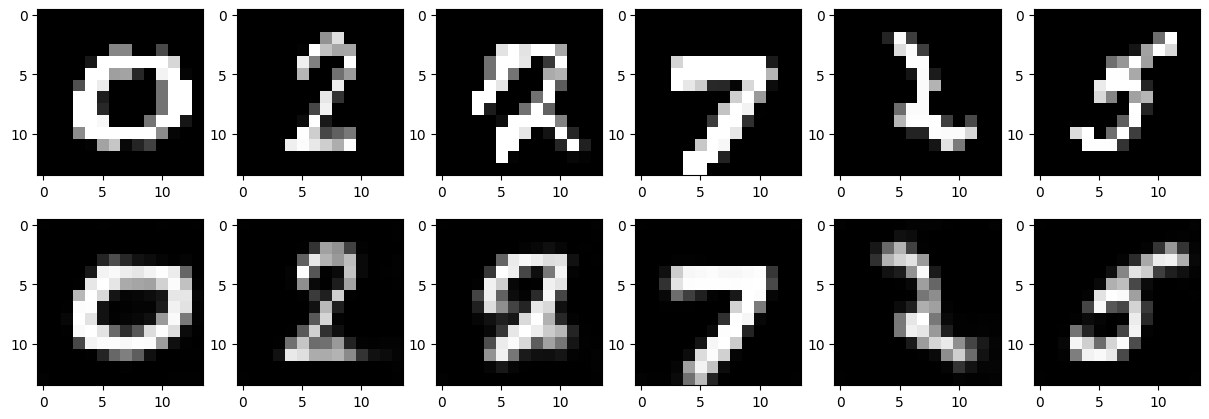

In [67]:
fig, ax = plt.subplots(2, 6, figsize = (15, 5))

for i, data in enumerate(train_loader):
    imgs, labels = data
    cur_sample_img = imgs[i]
    cur_sample_img = cur_sample_img[:, ::2, ::2]
    print(cur_sample_img.shape)
    
    ax[0][i].imshow(np.squeeze(cur_sample_img), cmap='gray') 
    
    gen_image = train_network.forward(cur_sample_img.unsqueeze(0))
    gen_image = gen_image[0].detach().numpy()
    ax[1][i].imshow(np.squeeze(gen_image), cmap='gray')
            
    


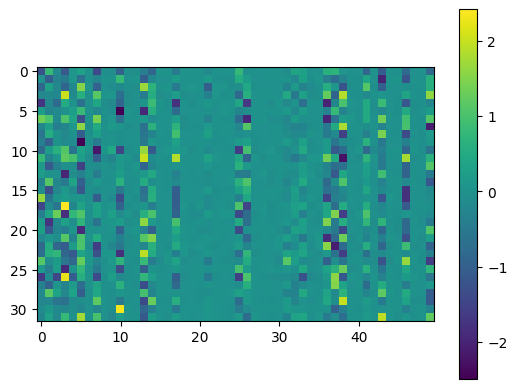

torch.Size([32, 50])


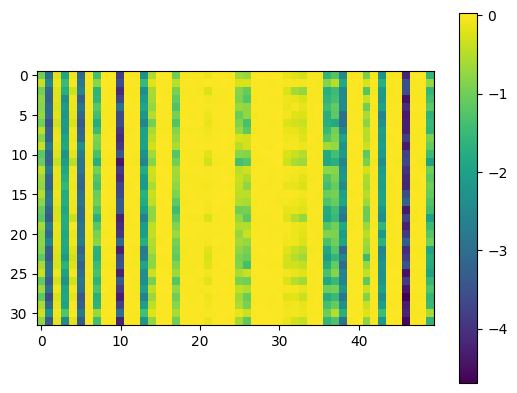

torch.Size([32, 50])


In [68]:
# The first image is the mean latent space.
# The second image is the variance latent space.

plt.imshow(latent_rep[0].detach().numpy())
plt.colorbar()
plt.show()
print(latent_rep[0].shape)

plt.imshow(latent_rep[1].detach().numpy())
plt.colorbar()
plt.show()
print(latent_rep[1].shape)

torch.Size([32, 1, 1, 1])
torch.Size([32, 1, 1, 1])


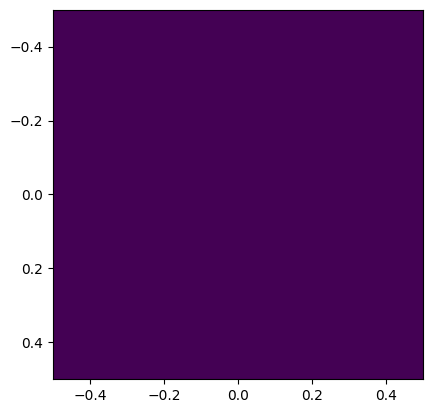

In [77]:
print(batch_images.shape)
batch_images = batch_images[:,:, ::2, ::2]
print(batch_images.shape)
plt.imshow(batch_images[0].squeeze(0).detach().numpy())

TypeError: 'Axes' object is not subscriptable

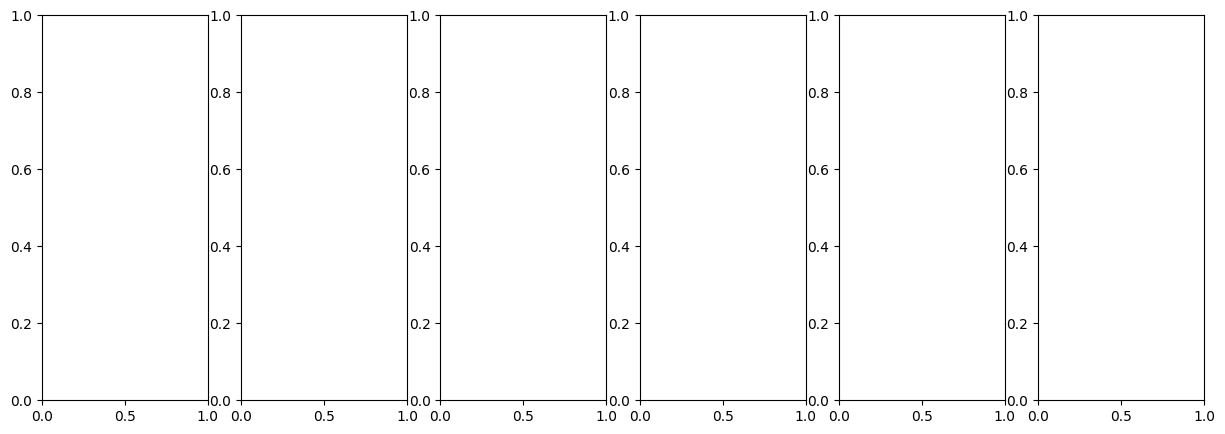

In [73]:
fig, ax = plt.subplots(1, 6, figsize = (15, 5))

for i in range(6):
    pannel = ax[0][i].imshow(np.squeeze(images[i].detach().numpy()), cmap='gray') 
    plt.colorbar(pannel, ax = ax[0][i])

In [23]:
    
images[:,0,6,2].std()

tensor(0.0037, grad_fn=<StdBackward0>)

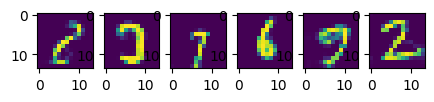

In [79]:
import random as rnd

figure, axx = plt.subplots(1, 6, figsize = (5, 5))


for l in range(6):
    # Randomly sample tensors:
    random_mean_sample = torch.randn(50)
    random_var_sample = torch.randn(50)
    #print(random_mean_sample)

    reparam_rnd_sample = train_network.reparametrization(random_mean_sample, random_var_sample)
    reparam_rnd_sample = reparam_rnd_sample.unsqueeze(0)

    random_sample = train_network.decode(reparam_rnd_sample).squeeze(0)

    axx[l].imshow(random_sample.squeeze(0).detach().numpy())
    

